<a href="https://colab.research.google.com/github/ArtAnichkin/msuai-hw/blob/main/EX10_Transformers_%D0%90%D0%BD%D0%B8%D1%87%D0%BA%D0%B8%D0%BD_%D0%90%D1%80%D1%82%D0%B5%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 1. "Естественность" языка

Одной из важных задач в NLP является оценка качества сгенерированного текста.
Одной из самых распорстранённых является [перплексия](https://habr.com/ru/companies/wunderfund/articles/580230/). Такой подход является классическим, существует целый ряд идейно близких метрик.

Сейчас появляются метрики, которые не просто "для нейросетей", они сами являются нейросетями. Одни из характерных представителей - [RuCoLa](https://habr.com/ru/articles/667336/). Это целый проект, со своим API и [лидербордом](https://rucola-benchmark.com/leaderboard).

Подобные рейтинги, кстати, позволяют нам выбирать модели под наши задачи.

Это модель, обученная на тщательно отобранных лингвистами вручную предложений, которая производит бинарную классификацию: *преемлемо* или *непреемлемо*.

Задачи:

* Возьмите 12 предложенных предложений, получите по ним цифры по метрикам RuCoLa и перплексия.

* Аугментируйте предложения с помощью библиотек для аугментации текстов, посчитайте по ним метрики
* Постройте "ящики с усами" по полученным цифрам для данных до и после аугментаци.
* Сравните по паре предложений с самымими худшими, самыми лучшими и пограничными значениями метрик.

In [ ]:
!pip install transformers --progress-bar off

import numpy as np
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Посмотрим, как получать метрику RuCoLa. `LABEL_1` означает, что предложение пригодное, `LABEL_0` — непригодное, `score` — степень уверенности модели в этом в промежутке от 0 до 1.

    
> Это специально обученная модель для выдачи метрик, применение к другим типам задач может привести к произвольным результатам или не сработать вовсе.



In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model = "RussianNLP/ruRoBERTa-large-rucola")

config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

Оценим текст, сгенерированный нейросетью.

In [ ]:
text_gen = ["Однажды вечером я решил приготовить борщ.",
            "Я купил все необходимое ингредиенты и начал готовить.",
            "Через несколько часов борщ готовился, и я решил приготовить блины и пельмени.",
            "Я начал приготавливать блины, используя те же ингредиенты, что и для борща.",
            "Я добавил муку, яйца, молоко, соль и перец, и смешал все вместе.",
            "Затем я выложил тесто в форму и выпекал блины.",
            "После того, как блины готовы, я начал приготавливать пельмени.",
            "Я добавил муку, яйца, молоко и соль, и смешал все вместе.",
            "Затем я выложил тесто в формы и выпекал пельмени.",
            "Когда борщ, блины и пельмени готовы, я подал все вместе на стол.",
             "Мы наслаждались вкусным борщем, блинами и пельменами.",
            "Это было настоящее удовольствие!"]

In [ ]:
gen = classifier(text_gen)

Посчитаем среднее качество текста и уверенность в ответе.

In [ ]:
def average_metric(res):
  good = 0
  bad = 0
  av_score = 0
  for i in range(len(res)):
    if res[i]['label'] == 'LABEL_1':
      good += 1
      av_score += res[i]['score']
    else:
      bad += 1
      av_score += res[i]['score']
  print ('Good:', round(good / len(res), 2))
  print ('Bad:', round(bad / len(res), 2))
  print ('Mean Score:', round(av_score/ len(res), 3))

In [ ]:
average_metric(gen)

Good: 0.5
Bad: 0.5
Mean Score: 0.941


Обратите внимание на разделение по классам. Вы, скорее всего, не являетесь профессиональным лингвистом, но, возможно, сможете оценить (не)естественность предложений.

Ниже, для примера, текст из учебника "Русский язык для иностранцев".

In [ ]:
text_real = ['Привет, любимая.',
 'Как дела?',
 'Что делаешь?',
 'Я сейчас в метро, еду на урок русского языка.',
 'Обычно я езжу на урок на метро.',
 'Метро - очень популярный вид транспорта в Москве, потому что в городе всегда пробки.',
 'Ты знаешь, что значит слово «пробка»?',
 'По-русски «пробка» - это когда на улице все машины стоят и не едут.',
 'А ещё пробка есть в бутылке.',
 'В метро всегда много народу и очень шумно.',
 'Но оно очень красивое, как музей.',
 'И ещё оно быстрое и удобное.']

In [ ]:
real = classifier(text_real)

In [ ]:
real

[{'label': 'LABEL_1', 'score': 0.99050372838974},
 {'label': 'LABEL_1', 'score': 0.9974937438964844},
 {'label': 'LABEL_1', 'score': 0.995926022529602},
 {'label': 'LABEL_1', 'score': 0.9944104552268982},
 {'label': 'LABEL_1', 'score': 0.9967597126960754},
 {'label': 'LABEL_0', 'score': 0.9188284873962402},
 {'label': 'LABEL_1', 'score': 0.9975433945655823},
 {'label': 'LABEL_1', 'score': 0.9933651089668274},
 {'label': 'LABEL_1', 'score': 0.9764190912246704},
 {'label': 'LABEL_1', 'score': 0.9939898252487183},
 {'label': 'LABEL_1', 'score': 0.9937877655029297},
 {'label': 'LABEL_1', 'score': 0.9942704439163208}]

In [ ]:
average_metric(real)

Good: 0.92
Bad: 0.08
Mean Score: 0.987


Воспользуемся метрикой [перплексия](https://habr.com/ru/companies/wunderfund/articles/580230/)

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
import numpy as np

model_name = 'cointegrated/rubert-tiny2'
model = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def score(model, tokenizer, sentence):
    tensor_input = tokenizer.encode(sentence, return_tensors='pt')
    repeat_input = tensor_input.repeat(tensor_input.size(-1)-2, 1)
    mask = torch.ones(tensor_input.size(-1) - 1).diag(1)[:-2]
    masked_input = repeat_input.masked_fill(mask == 1, tokenizer.mask_token_id)
    labels = repeat_input.masked_fill( masked_input != tokenizer.mask_token_id, -100)
    with torch.inference_mode():
        loss = model(masked_input, labels=labels).loss
    return np.exp(loss.item())

print(score(sentence='London is the capital of Great Britain.', model=model, tokenizer=tokenizer))
print(score(sentence='London is the capital of South America.', model=model, tokenizer=tokenizer))

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

13.606421093211964
16.027210581101514


Посчитайте перплексию для текстов text_gen и text_real, а также средние значения метрик.

In [ ]:
perplex_text_gen = [score(sentence=text, model=model, tokenizer=tokenizer) for text in text_gen]
perplex_text_real = [score(sentence=text, model=model, tokenizer=tokenizer) for text in text_real]

In [ ]:
print(np.mean(perplex_text_gen))
print(np.mean(perplex_text_real))

22.12310640464277
38.35797710748808


Возьмите библиотеку аугментации текстов `nlpaug` из прошлой лекции и попортите оба текста. Посчитайте по ним перплексию, RuCoLa и средние значения RuCoLa функцией выше.

In [ ]:
# library for augmentation
!pip install -q nlpaug
# words augmentation libraries
import nlpaug.augmenter.word as naw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.3 MB/s eta 0:00:00


In [ ]:
augment = naw.ContextualWordEmbsAug(model_path="cointegrated/rubert-tiny2", action="substitute", aug_p = 0.2)
augmented_text_gen = augment.augment(text_gen)

augmented_text_gen

['Однажды вечером я узнал этот борщ.',
 'Я выбрал все необходимые ингредиенты и начал готовить.',
 'Через несколько часов вечером готовился, и уже решил сменить кухню и пельмени.',
 'Я начал принимать блины, все те же методы, что и этого борща.',
 'Я добавил ее, яйца, молоко, соль и соль, дайте собрать все вместе.',
 'Затем я открыла картинку в форму и выпекал краску.',
 'Сравнение сравнения, что блины готовы, чеснок начал приготавливать пельмени.',
 'Я добавил муку, яйца, молоко добавить муку, кофе смешал все больше.',
 'Затем я выложил тесто в формы можно создать краску.',
 'Когда кричат, блины с пельмени готовы, я подал заявку вместе за стол.',
 'Если наслаждались вкусным борщем, общаться со пельменами.',
 'Это и настоящее удовольствие!']

Посчитайте метрики.

In [ ]:
gen_aug = classifier(augmented_text_gen)
gen_aug

[{'label': 'LABEL_0', 'score': 0.8545178771018982},
 {'label': 'LABEL_1', 'score': 0.9951352477073669},
 {'label': 'LABEL_0', 'score': 0.9964098334312439},
 {'label': 'LABEL_0', 'score': 0.9960700273513794},
 {'label': 'LABEL_0', 'score': 0.9005478024482727},
 {'label': 'LABEL_0', 'score': 0.9966421127319336},
 {'label': 'LABEL_0', 'score': 0.9944728016853333},
 {'label': 'LABEL_0', 'score': 0.9922420978546143},
 {'label': 'LABEL_0', 'score': 0.989287257194519},
 {'label': 'LABEL_0', 'score': 0.9977891445159912},
 {'label': 'LABEL_0', 'score': 0.9927104711532593},
 {'label': 'LABEL_0', 'score': 0.9920610189437866}]

In [ ]:
average_metric(gen_aug)

Good: 0.08
Bad: 0.92
Mean Score: 0.975


In [ ]:
perplex_augmented_text_gen = [score(sentence=text, model=model, tokenizer=tokenizer) for text in augmented_text_gen]
np.mean(perplex_augmented_text_gen)

38.41599590389658

Сделайте аугментацию второго текста

In [ ]:
augmented_text_real = augment.augment(text_real)

augmented_text_real

['Привет, нет.',
 'Пусть дела?',
 'Что сделать?',
 'Я живёт в метро, еду и пределами русского языка.',
 'Обычно я езжу наш урок на занятия.',
 'Метро - метро удобен трафик транспорта в Москве, потому что в стране всегда пробки.',
 'Ты знаешь, что значит слово « Москва была?',
 'По - русски большая пробка » - но прямо на стоянке все машины стоят и не едут.',
 'Есть ещё лучше есть в бутылке.',
 'В метро она предлагает народу и очень шумно.',
 'А оно очень здорово, как музей.',
 'И ещё есть быстрое самое удобное.']

Посчитайте метрики.

In [ ]:
real_aug = classifier(augmented_text_real)
real_aug

[{'label': 'LABEL_0', 'score': 0.9402563571929932},
 {'label': 'LABEL_0', 'score': 0.9952301979064941},
 {'label': 'LABEL_1', 'score': 0.9973850846290588},
 {'label': 'LABEL_0', 'score': 0.9965550899505615},
 {'label': 'LABEL_0', 'score': 0.9959048628807068},
 {'label': 'LABEL_0', 'score': 0.9959533214569092},
 {'label': 'LABEL_0', 'score': 0.8466139435768127},
 {'label': 'LABEL_0', 'score': 0.5191309452056885},
 {'label': 'LABEL_0', 'score': 0.9906927943229675},
 {'label': 'LABEL_0', 'score': 0.9917740225791931},
 {'label': 'LABEL_1', 'score': 0.6366013288497925},
 {'label': 'LABEL_0', 'score': 0.9704298377037048}]

In [ ]:
average_metric(real_aug)

Good: 0.17
Bad: 0.83
Mean Score: 0.906


In [ ]:
perplex_augmented_text_real = [score(sentence=text, model=model, tokenizer=tokenizer) for text in augmented_text_real]
np.mean(perplex_augmented_text_real)

97.66341538689234

Рассчитайте ящики с усами по обоим метрикам. Для это постройте два subplot'a, на каждом из них выведите по 4 ящика. На левом subplot'е — RuCoLa, на правом — перплексия.

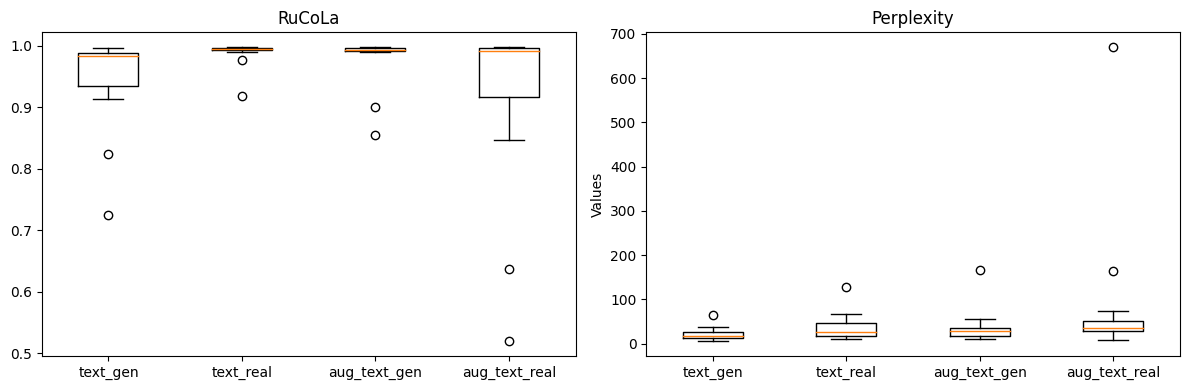

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Male subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Lists with metrics
scores_rucola = [[d['score'] for d in gen], [d['score'] for d in real], [d['score'] for d in gen_aug], [d['score'] for d in real_aug]]
scores_perplexity = [perplex_text_gen, perplex_text_real, perplex_augmented_text_gen, perplex_augmented_text_real]

# Dict
data_r = {
    'text_gen': scores_rucola[0],
    'text_real': scores_rucola[1],
    'aug_text_gen': scores_rucola[2],
    'aug_text_real': scores_rucola[3],
}
data_p = {
    'text_gen': scores_perplexity[0],
    'text_real': scores_perplexity[1],
    'aug_text_gen': scores_perplexity[2],
    'aug_text_real': scores_perplexity[3],
}

axes[0].boxplot(data_r.values())
axes[0].set_xticklabels(data_r.keys())
axes[0].set_title('RuCoLa')


axes[1].boxplot(data_p.values())
axes[1].set_xticklabels(data_p.keys())
axes[1].set_title('Perplexity')

plt.ylabel('Values')

plt.tight_layout()
plt.show()

Можно ли делать вывод о качестве текстов (а значит, и моделей, которые их порождают)?

По rucola судить о качестве текста можно косвено, модель явно хорошо определяет, что text\_real - хороший, а aug\_text\_gen плохой. По perplexity все сложнее, она считает text\_gen более хороший, чем text\_real, что даже визуально не так

In [ ]:
print('Худший текст:', augmented_text_real[np.argmax(perplex_augmented_text_real)])

Худший текст: Пусть дела?


In [ ]:
print('Лучший текст:', text_gen[np.argmin(perplex_text_gen)])

Лучший текст: После того, как блины готовы, я начал приготавливать пельмени.


Ну короче мем

**Дополнительно**

* Можно взять весь [датасет RuCoLa](https://github.com/RussianNLP/RuCoLA) и проверить его согласно метрикам RuCoLa и перплексия, построить "ящики с усами".

Для скачивания датасета можно воспользоваться командой:


```
!git clone https://github.com/RussianNLP/RuCoLA.git data/data
```



## Формат результата

Получить "ящики с усами" метрик.

# Задание 2. Классификация с помощью BERT

Возьмите набор данных эмоциональных окрасок отзывов [emotions dataset](https://huggingface.co/datasets/emotion). В датасете 5 классов. Получите эмбеддинг из BERT-подобного кодировщика, классифицируйте тексты с помощью методов ML или  нейростеи, использовав эмбеддинги в качестве входов.

Произведите fine-tuning кодировщика на ваших данных (классификатор на основе bert), и сравните, как изменилось качество классификации.

In [ ]:
!pip install -q -U transformers accelerate git+https://github.com/huggingface/peft.git datasets evaluate --progress-bar off

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import torch
from datasets import load_dataset
import warnings

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Взглянем на датасет.

In [ ]:
train = load_dataset("SetFit/emotion", split="train")
train_df = pd.DataFrame({"text": train["text"], "labels": train["label"]})
train_df.head()

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

,text,labels
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Инициализация токенайзера и модели. Перед тем, как отправить текст в модель, его следует токенизировать.

**Учитывайте**, что:
* Мы посмотрели несколько способов добывания эмбеддингов из моделей BERT
* Длина эмбеддинга длинее 312 в данной задаче не потребуется. Чем длинее эмбеддинг, тем медленнее всё будет учиться.
* В каждой части задания нужно задать по отдельной модели.
* Библиотеки в первой части задания и второй могут конфликтовать. Используйте "перезапуск сеанса", если так случилось.




Возьмите модель `bert-tiny` и соответствующий токенизатор.

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
import numpy as np

from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("lyeonii/bert-tiny", model_max_length=256)
model = AutoModel.from_pretrained("lyeonii/bert-tiny")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-1): 2 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=128, out_features=128, bias=True)
            (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [ ]:
model.pooler = torch.nn.Identity()

Посмотрим, как устроен датасет, какой у него балланс классов:

In [ ]:
pd.pivot_table(train_df, values='text', index='labels', aggfunc="count")

,text
labels,
0,4666
1,5362
2,1304
3,2159
4,1937
5,572


Оставьте 5000 объектов, поделив их на обучение, валидацию, тест.

Если вы будете семплировать, в функцию `sample` из `pandas` можно подать то, с какими весами будет происходить семплирование. Один из вариантов - создать столбец, в каждой строке которой будет необходимая частота семплирования. И именно этот объект нужно подавать в качестве весов.

In [ ]:
def func(labels):
    weights = [0.1, 0.1, 0.4, 0.3, 0.3, 1]
    return weights[labels]

In [ ]:
train_df['weights'] = train_df['labels'].apply(func)

In [ ]:
train_df_s = train_df.sample(5000, weights='weights')

In [ ]:
pd.pivot_table(train_df_s, values='text', index='labels', aggfunc="count")

,text
labels,
0,874
1,1031
2,734
3,989
4,868
5,504


Таеже имеет смысл проверить, что в колонке `labels` данные типа `int`. Если нет - привести к этмоу типу.

In [ ]:
train_df_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 4579 to 8578
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   text     5000 non-null   object 
 1   labels   5000 non-null   int64  
 2   weights  5000 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 156.2+ KB


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(train_df_s, stratify=train_df_s['labels'], test_size=0.2)

Проверьте, сколько и каких объектов у вас в метках в трёх выборках.

In [ ]:
X_train.shape

(4000, 3)

In [ ]:
X_test.shape

(1000, 3)

Смотреть сколько каких объектов не имеет большого смысла при использовании стартификации, распределение будет тоже самое что и у train_df

Сохраните эмбеддинги модели и постройте поверх них классификатор.

In [ ]:
tokenized_train = tokenizer(X_train["text"].values.tolist(), padding = 'max_length', truncation = True, return_tensors="pt")
tokenized_test = tokenizer(X_test["text"].values.tolist() , padding = 'max_length', truncation = True,  return_tensors="pt")

tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
tokenized_test = {k:torch.tensor(v).to(device) for k,v in tokenized_test.items()}

In [ ]:
with torch.no_grad():
    hidden_train = model(**tokenized_train) #dim : [batch_size(nr_sentences), tokens, emb_dim]
    hidden_test = model(**tokenized_test)

#get only the [CLS] hidden states
train_tok = hidden_train.last_hidden_state[:,0,:]
test_tok = hidden_test.last_hidden_state[:,0,:]

Возьмите ML-классификатор, обучите его и постройте `classification_report`.

Базово можно взять `RandomForestClassifier`.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([('clf', RandomForestClassifier(random_state=100423))])

grid={
    'clf__max_depth':list(np.arange(3, 50, step=3)),
    'clf__n_estimators':np.arange(10, 100, step=10),
    'clf__max_features':np.arange(1, 7),
    'clf__min_samples_leaf':np.arange(1, 4),
    'clf__min_samples_split':np.arange(2, 10, step=2)
}

cl = RandomizedSearchCV(pipe, grid, n_iter=10, cv=3, scoring='balanced_accuracy', n_jobs=-1, random_state=100423)
cl.fit(train_tok.cpu(), X_train['labels']);

In [ ]:
cl.best_score_

0.3102501684850533

In [ ]:
from sklearn.metrics import classification_report
y_pred = cl.predict(test_tok.cpu())
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
print(classification_report(X_test['labels'], y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.33      0.27      0.30       175
     class 1       0.33      0.53      0.41       206
     class 2       0.41      0.28      0.33       147
     class 3       0.32      0.46      0.38       198
     class 4       0.33      0.25      0.28       173
     class 5       0.50      0.04      0.07       101

    accuracy                           0.34      1000
   macro avg       0.37      0.31      0.30      1000
weighted avg       0.36      0.34      0.32      1000



Здесь не требуется получить 100% Presicion и Recall. Однако проверьте, что вы верно разделили на 3 подвыборки и что значения метрик не в раайоне нуля.

In [ ]:
X_train, X_val = train_test_split(X_train, stratify=X_train['labels'], test_size=0.25)

**Попробуйте дообучить BERT и произвести классификацию заново**

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [ ]:
import datasets

from datasets.dataset_dict import DatasetDict
from datasets import Dataset

d = {'train':Dataset.from_dict({'label':X_train['labels'],'text':X_train['text']}),
     'val':Dataset.from_dict({'label':X_val['labels'],'text':X_val['text']}),
     'test':Dataset.from_dict({'label':X_test['labels'],'text':X_test['text']})
     }

dataset = DatasetDict(d)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
})

Импортируйте токенизатор. Имеет смысл указать длину получаемых векторных представлений (`model_max_length`).

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("lyeonii/bert-tiny", model_max_length=256)

Напищите функцию, которая будет токенизировать ваш текст в `DatasetDict`.

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"] , padding = 'max_length', truncation = True,  return_tensors="pt")


Токенизируйте ваши данные

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Проверьте внешний вид вашего DatasetDict, размеры объектов, которые он содержит.

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
})

In [ ]:
len(tokenized_dataset['train']['token_type_ids'][0])


256

Импортируйте модель с учётом того, что вы уже решаете не просто задачу построения эмбеддингов, а задачу классификации.

In [ ]:
from transformers import AutoModelForSequenceClassification

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    "lyeonii/bert-tiny", num_labels=6
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at lyeonii/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

Задайте параметры, обучите модель

In [ ]:
from transformers import Trainer, TrainingArguments

# Your code here
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)



trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_dataset['train'],         # training dataset
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,1.701614,0.267247
2,No log,1.628464,0.383658
3,1.672400,1.542030,0.450101
4,1.672400,1.458869,0.518978
5,1.672400,1.386701,0.569734
6,1.473900,1.329508,0.592295
7,1.473900,1.286813,0.614755
8,1.309500,1.256412,0.635677
9,1.309500,1.237746,0.644801
10,1.309500,1.231732,0.643824


Checkpoint destination directory my_awesome_model/checkpoint-188 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory my_awesome_model/checkpoint-376 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory my_awesome_model/checkpoint-564 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory my_awesome_model/checkpoint-752 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1880, training_loss=1.4354007639783495, metrics={'train_runtime': 95.9199, 'train_samples_per_second': 312.761, 'train_steps_per_second': 19.6, 'total_flos': 19081082880000.0, 'train_loss': 1.4354007639783495, 'epoch': 10.0})

Мы дообучили модель. Теперь проверим качество предсказания на тесте.

Можете использовать `trainer.predict`

In [ ]:
log = trainer.predict(tokenized_dataset['test'])

In [ ]:
log.metrics

{'test_loss': 1.2502248287200928,
 'test_f1': 0.5893737069102704,
 'test_runtime': 4.4343,
 'test_samples_per_second': 225.514,
 'test_steps_per_second': 14.207}

In [ ]:
from sklearn.metrics import classification_report
y_pred = np.argmax(log.predictions, axis=1)
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
print(classification_report(X_test['labels'], y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.56      0.50      0.53       175
     class 1       0.54      0.58      0.56       206
     class 2       0.58      0.57      0.58       147
     class 3       0.62      0.43      0.51       198
     class 4       0.58      0.80      0.68       173
     class 5       0.79      0.79      0.79       101

    accuracy                           0.59      1000
   macro avg       0.61      0.61      0.61      1000
weighted avg       0.60      0.59      0.59      1000



**Дополнительно**

* Попробуйте классифицировать, использовав такие методы, как TF-IDF, word2vec и другие.

* Попробуйте использовать косинусную меру для оценки близости текстов. Получается ли с её помощью разделять классы?

## Формат результата

Получить значение качества классификации

# Задание 3. Генерация текста

Возьмите произведение Гете "Фауст" и обучите на нем модель  генерации текста.

При обучении игнорируйте знаки препинания и номера страниц.

Используйте предобученную модель `sberbank-ai/rugpt3small_based_on_gpt2` из библиотеки Hugging Face. Попробуйте разные параметры модели (например, разные режимы генерации). Как меняется результат?


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import random
import torch


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

In [ ]:
!pip install -q -U transformers accelerate git+https://github.com/huggingface/peft.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 28.1 MB/s eta 0:00:00


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Загрузка и подготовка данных

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/Faust.txt

In [ ]:
with open("hp.txt") as text_file:
    faust_text = "".join(text_file.readlines())

In [ ]:
faust_text

'    \n   Джоан Кэтлин Роулинг \n   Гарри Поттер и философский камень \n    \n   Глава первая \n   Мальчик, который выжил \n    \n   Мистер и миссис Дарсли, из дома номер четыре по Бирючинному проезду, могли бы \nс гордостью сказать, что они, слава богу, совершенно нормальные люди. Они были \nбы последними, от кого вы могли бы ожидать участия в чем-нибудь странном и \nтаинственном, потому что они совершенно не одобряли подобной чепухи. \n   Мистер Дарсли работал директором фирмы Граннингз, которая выпускала сверла. Он \nбыл крупный, крепкий мужчина с очень короткой шеей и очень большими усами. \nМиссис Дарсли была худой и светловолосой, зато ее шеи с лихвой хватило бы на \nдвоих. Этим подарком природы она усердно пользовалась, большую часть времени \nшпионя за соседями через садовые изгороди. У Дарсли рос сын Дадли, и они были \nуверены, что лучшего мальчика не сыщешь на всем свете. \n   У Дарсли было все что нужно, но кроме того, у них была тайна, и больше всего \nони боялись, что кто

In [ ]:
len(faust_text.split(' '))

76422

Удалим знаки управляющих символов и приведем текст к нижнему регистру:

In [ ]:
text = faust_text.replace('\n', ' ').replace('\r', '').replace('\ufeff', '').replace('\x0c', '').replace('—', '')
text = "".join([char for char in text if char.isalpha() or char == ' '])
text = text.lower()

In [ ]:
text

'        джоан кэтлин роулинг     гарри поттер и философский камень          глава первая     мальчик который выжил          мистер и миссис дарсли из дома номер четыре по бирючинному проезду могли бы  с гордостью сказать что они слава богу совершенно нормальные люди они были  бы последними от кого вы могли бы ожидать участия в чемнибудь странном и  таинственном потому что они совершенно не одобряли подобной чепухи     мистер дарсли работал директором фирмы граннингз которая выпускала сверла он  был крупный крепкий мужчина с очень короткой шеей и очень большими усами  миссис дарсли была худой и светловолосой зато ее шеи с лихвой хватило бы на  двоих этим подарком природы она усердно пользовалась большую часть времени  шпионя за соседями через садовые изгороди у дарсли рос сын дадли и они были  уверены что лучшего мальчика не сыщешь на всем свете     у дарсли было все что нужно но кроме того у них была тайна и больше всего  они боялись что ктонибудь раскроет её они с ужасом представляли

Запишем обработанные данные в текстовый файл:

In [ ]:
with open("Faust_cl.txt", "w") as f:
    f.write(text)

## Предобученная sberbank-ai GPT2

Возьмите предобученную модель и попробуйте сгенерировать текст с ее помощью. Оцените результаты.

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel


model_name_or_path = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path, model_max_length=2048)
model = GPT2LMHeadModel.from_pretrained(model_name_or_path, )

input_ids = tokenizer.encode(text, return_tensors="pt")
model.eval()
with torch.no_grad():
    sample_output = model.generate(input_ids,
                                do_sample=True,
                                temperature=1.5,
                                top_k=20,
                                top_p=0.9,
                                max_length=100,
                                )

generated_text = tokenizer.decode(sample_output[0], skip_special_tokens=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (93016 > 2048). Running this sequence through the model will result in indexing errors


IndexError: index out of range in self

In [ ]:
print(generated_text)

Это лучшее что получилось)

## Файнтюнинг sberbank-ai GPT2

Дообучите модель. Для этого сначала создадим датасет и `data_collator`, который нарезает текст на оптимальные по длине куски:

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from warnings import simplefilter

simplefilter("ignore", category=FutureWarning)

train_path = 'hp.txt'

train_dataset = TextDataset(tokenizer=tokenizer, file_path=train_path, block_size=64)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
from transformers import Trainer, TrainingArguments

model.to(device)

# Your code here
training_args = TrainingArguments(
    output_dir="./finetuned", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=10, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    warmup_steps=10,# number of warmup steps for learning rate scheduler
    gradient_accumulation_steps=16, # to make "virtual" batch size larger
    save_strategy="epoch",
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers=(
        torch.optim.AdamW(model.parameters(), lr=1e-5),
        None
    )
)

In [ ]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=30, training_loss=3.4699188232421876, metrics={'train_runtime': 247.0122, 'train_samples_per_second': 75.624, 'train_steps_per_second': 0.121, 'total_flos': 496454860800000.0, 'train_loss': 3.4699188232421876, 'epoch': 8.14})

In [ ]:
# Пример вероятностного сэмплирования с ограничением
text = "Гарри Поттер"
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids,
                        do_sample=True,
                        num_beams=1,
                        temperature=1.5,
                        top_p=0.9,
                        max_length=200,
                        )

generated_text = list(map(tokenizer.decode, out))[0]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
print(generated_text)

Гарри Поттер, как и Драко".
 - Это невозможно, - сказала она в 
минуту молчания. - И мы не хотим так разговаривать, хорошо? Ты меня слышишь, и можешь повторить, если 
хочешь". И они рассмеялись. Когда Гарри Поттер перестал кашлять, их смех 
развился, в комнату вошел Дамблдор, который, глядя на Снейпа, сказал: - Спасибо вам. 
Что происходит? Мы так хотели поговорить! 
   "Остановитесь!" - скомандовал Гарри, но он все же не успел. Его слова 
здорово унеслись к нему в 
трубах: так громко, что эхом раскатилось наверху, среди 
фонариков, что под ногами у Гарри втащили во второй 
кабинет, где его уже не ожидали, все еще сидевшие там 
зайчики. Когда они пришли в его кабинет и, встав рядом 
с Гарри в руках, принялись рассматривать Гарри


## Другая модель с HuggingFace

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, ByT5Tokenizer, T5ForConditionalGeneration


tokenizer = GPT2Tokenizer.from_pretrained('cometrain/neurotitle-rugpt3-small')
model = GPT2LMHeadModel.from_pretrained('cometrain/neurotitle-rugpt3-small')


tokenizer_config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/668 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling

train_path = 'hp.txt'

train_dataset = TextDataset(tokenizer=tokenizer, file_path=train_path, block_size=64)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
from transformers import Trainer, TrainingArguments

model.to(device)

# Your code here
training_args = TrainingArguments(
    output_dir="./finetuned", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=20, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    warmup_steps=10,# number of warmup steps for learning rate scheduler
    gradient_accumulation_steps=16, # to make "virtual" batch size larger
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers=(
        torch.optim.AdamW(model.parameters(), lr=1e-5),
        None
    )
)

In [ ]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=60, training_loss=3.0969469706217447, metrics={'train_runtime': 504.3759, 'train_samples_per_second': 74.072, 'train_steps_per_second': 0.119, 'total_flos': 992909721600000.0, 'train_loss': 3.0969469706217447, 'epoch': 16.27})

In [ ]:
# Example of probability sampling with restrictions
text = "Ты волшебник, Гарри"
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids,
                        do_sample=True,
                        num_beams=1,
                        temperature=1.3,
                        top_p=0.8,
                        max_length=200,
                        pad_token_id=tokenizer.eos_token_id,
                        )

generated_text = list(map(tokenizer.decode, out))[0]

In [ ]:
print(generated_text)

Ты волшебник, Гарри.
Ты можешь убить любую тварь, кроме Дамблдора. Я буду знать это и покажу тебе то, что Дамблдор любит все знать, но ты знаешь, как заставить Снейпа ненавидеть всех людей, кроме Снейпа. Он любит всех, кроме 
Снейпа. Так же он любит Гермиону и, надеюсь, что никогда не забывает свою 
имени, потому что она не умеет пользоваться волшебством, но ей очень повезло, что 
не может его убить, потому что она всегда знала, что Гарри не сможет причинить 
уничтожающий, смертельный вред Снейпу. Дамблдор знает все про Снейпа: если 
он убьет его, Гарри погибнет!" 

Гарри поднял глаза. 
   "Ты меня пугаешь. И все, что я знаю - это, конечно, то, как вы это сделали". 
   "А как вы узнали, почему он так ненавидит меня? - спросила Гермиона. - Если 



Очень сильно на адекватность выхода влияет num_beams

## Формат результата

Сгенерерированный текст

Пример текста:

"все все от бесстыдные старой

все в нем получше все стремленья

поддержки с собой в сердце воздух своей

и в вечной страсти восстанет свой предлог

привет вам слуга в сладком страшней стране

и в мире все вражда станет станет

в поле на пользу своим воспоминанья"


# Задание 4. QLoRa

Дообучите большую языковую модель для классификации текстов. В этом задании мы предлагаем базово взять готовый датасет, загрузка которого обозначена ниже.


> В качестве **дополнительного** задания - предлагаем взять датасет с русским языком, выбрать подходящую модель и провести классификацию.



> Расположен [датасет на kaggle](https://www.kaggle.com/datasets/dadalyndell/early-news-articles-on-hivaids-1987-1997-ru). В нём  собраны новости Российских газет конца прошлого века по теме ВИЧ. Из архива вам потребуется файл hiv_pub.csv, в котором представлены тексты и названия изданий.

> Попробуйте определить, к какому изданию относится тот или иной текст. Для этого вам потребуется разделить данные на подвыборки, подготовить промты и выполнить несколько эпох обучения.



In [ ]:
import math

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn

import random
import torch


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes==0.41.3 einops #wndb
!pip install -q peft==0.6.2

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 963.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 4.1 MB/s eta 0:00:00


#Загрузка и подготовка данных

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "TinyPixel/Llama-2-7B-bf16-sharded"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float32
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map= 'auto',
    trust_remote_code=True
)
model.config.use_cache = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/626 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-00014.safetensors:   0%|          | 0.00/981M [00:00<?, ?B/s]

KeyboardInterrupt: 

Загрузите токенизатор. Вам может помочь параметр `trust_remote_code=True`.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token = False)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:690: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

Воспользуйтесь библиотекой peft и настройте peft_config.

In [ ]:
from peft import LoraConfig, get_peft_model


peft_config = LoraConfig(
    lora_alpha=64,
    lora_dropout=0.1,
    r=16,
    bias='none',
    task_type="CAUSAL_LM"
)

Загрузите датасет

In [ ]:
from datasets import load_dataset

dataset_name = 'AlexanderDoria/novel17_test' #french novels
dataset = load_dataset(dataset_name, split="train")

Generating train split: 0 examples [00:00, ? examples/s]

Failed to read file '/root/.cache/huggingface/datasets/downloads/72447e5f4c7614bfadde8cf83a8856e0287a209c678306f17b0744fec3cba401' with error <class 'pyarrow.lib.ArrowInvalid'>: JSON parse error: The document is empty.
ERROR:datasets.packaged_modules.json.json:Failed to read file '/root/.cache/huggingface/datasets/downloads/72447e5f4c7614bfadde8cf83a8856e0287a209c678306f17b0744fec3cba401' with error <class 'pyarrow.lib.ArrowInvalid'>: JSON parse error: The document is empty.


DatasetGenerationError: An error occurred while generating the dataset

Загрузите трейнер и подайте в него параметры

In [ ]:
from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 1
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 100
logging_steps = 1
learning_rate = 2e-5
#max_grad_norm = # Your code here
max_steps = 20
#warmup_ratio = # Your code here
#lr_scheduler_type = # Your code here

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    #max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    #warmup_ratio=warmup_ratio,
    group_by_length=True,
    #lr_scheduler_type=lr_scheduler_type,
)

Подайте всё в трейнер

In [ ]:
from trl import SFTTrainer

max_seq_length = 512

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset, #your dataset
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:247: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [ ]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

In [ ]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:228: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')


Step,Training Loss
1,0.983900
2,0.977900
3,0.971300
4,0.965100
5,0.960000
6,0.954200
7,0.949300
8,0.944100
9,0.938900
10,0.936900


TrainOutput(global_step=20, training_loss=0.9385302931070327, metrics={'train_runtime': 29.2948, 'train_samples_per_second': 2.731, 'train_steps_per_second': 0.683, 'total_flos': 240548023664640.0, 'train_loss': 0.9385302931070327, 'epoch': 20.0})

## Формат результата

Метрики обучения, результаты классификации

<center><img src ="https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/loss-falcon-7b.png" width="600"></center>

